In [1]:
# !pip install catboost

In [2]:
from catboost import CatBoostRanker, Pool, MetricVisualizer, cv

import pandas as pd

# Read data

In [115]:
USE_FULL = True

filename = 'data/training_set_VU_DM.csv'

if USE_FULL:
    df = pd.read_csv(filename)
else:
    import random
    p = 0.1
    df = pd.read_csv(filename,
                     header=0,
                     skiprows=lambda i: i > 0 and random.random() > p)

df['date_time'] = pd.to_datetime(df['date_time'])
df.shape

(4958347, 54)

In [58]:
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,27,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,1,2.20,0.0149,5.03,26,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,1,2.20,0.0245,4.92,21,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,1,2.83,0.0125,4.39,34,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,-1.0,0.0,5.0,-1.0,0.0,5.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,4,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


# Simple preproc + split

In [116]:
CAT_FEATURES = ['site_id',
            'visitor_location_country_id',
            'prop_country_id',
            'prop_id',
            'srch_destination_id']

bool_cols = ['prop_brand_bool',
             'promotion_flag',
             'srch_saturday_night_bool',
             'random_bool']

group_col = 'srch_id'

ranking_target = 'position'



def get_target(row):
    """
    0=not clicked at all, 1=clicked but not booked, 5=booked
    """
    if row.booking_bool>0:
        return 5
    if row.click_bool>0 :
        return 1
    return 0

In [111]:
from sklearn.model_selection import train_test_split

df.sort_values([group_col, 'date_time'], inplace=True)
# X = df.drop(['position', 'click_bool', 'gross_bookings_usd', 'booking_bool'], axis=1)
y = df[ranking_target]
groups = X[group_col]


X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.1, shuffle=False)  # violates grouping
X_train = X_train.drop(['position', 'click_bool', 'gross_bookings_usd', 'booking_bool'], axis=1)

# from sklearn.model_selection import GroupShuffleSplit  # ignores time
# gss = GroupShuffleSplit(n_splits=2, train_size=.7, random_state=42)
# >>> gss.get_n_splits()
# 2
# >>> for train_idx, test_idx in gss.split(X, y, groups):
# ...     print("TRAIN:", train_idx, "TEST:", test_idx)

test_pool = Pool(
    data=X_test.drop(['position', 'click_bool', 'gross_bookings_usd', 'booking_bool'], axis=1),
    label=y_test,
    group_id=groups_test,
    cat_features=CAT_FEATURES,
)

violation

In [213]:
set(X_train[group_col]).intersection(set(X_test[group_col]))

{299424}

In [67]:
train_pool = Pool(data=X_train,
                  label=y_train,
                  group_id=groups_train,
                  cat_features=CAT_FEATURES,
                  )

# Cross-validation

In [70]:
%%time

params = {
    "iterations": 1000,
    #           'loss_function': 'NDCG:top=5',
    'loss_function': 'QueryRMSE',
    'custom_metric': [
        'NDCG:top=5;type=Base;denominator=LogPosition'
        #                       , 'PFound', 'AverageGain:top=10'
    ],
    "verbose": False,
    'early_stopping_rounds': 50,
    #     'logging_level': 'Silent',
}

cv_results, fitted_models = cv(train_pool, params, nfold=3, type='TimeSeries', plot=True,
                               return_models=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 7.84580633
bestIteration = 999

Training on fold [1/3]

bestTest = 7.716855565
bestIteration = 999

Training on fold [2/3]

bestTest = 7.681842343
bestIteration = 999

CPU times: user 4h 50min 8s, sys: 17min 54s, total: 5h 8min 2s
Wall time: 55min 31s


In [72]:
cv_results

,iterations,test-QueryRMSE-mean,test-QueryRMSE-std,train-QueryRMSE-mean,train-QueryRMSE-std,test-NDCG:top=5;type=Base-mean,test-NDCG:top=5;type=Base-std
0,0,9.619634,0.014706,9.631591,0.014819,0.580885,0.052610
1,1,9.575564,0.024417,9.589597,0.022692,0.624434,0.051722
2,2,9.533265,0.034198,9.549048,0.030734,0.636590,0.061763
3,3,9.492343,0.043957,9.510407,0.038329,0.639473,0.063749
4,4,9.453758,0.053120,9.473526,0.045893,0.656692,0.040939
5,5,9.414847,0.062849,9.435897,0.054333,0.658349,0.042181
6,6,9.371752,0.060806,9.395619,0.053562,0.685685,0.003066
7,7,9.331434,0.059266,9.358953,0.053574,0.694048,0.009594
8,8,9.292521,0.058912,9.322934,0.054781,0.702955,0.016308
9,9,9.254033,0.058664,9.287187,0.056124,0.709218,0.009039


In [73]:
model = fitted_models[-1]

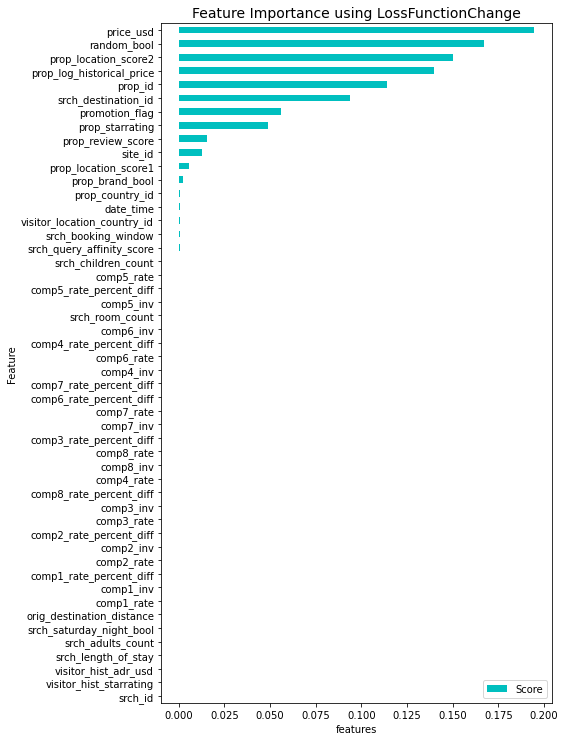

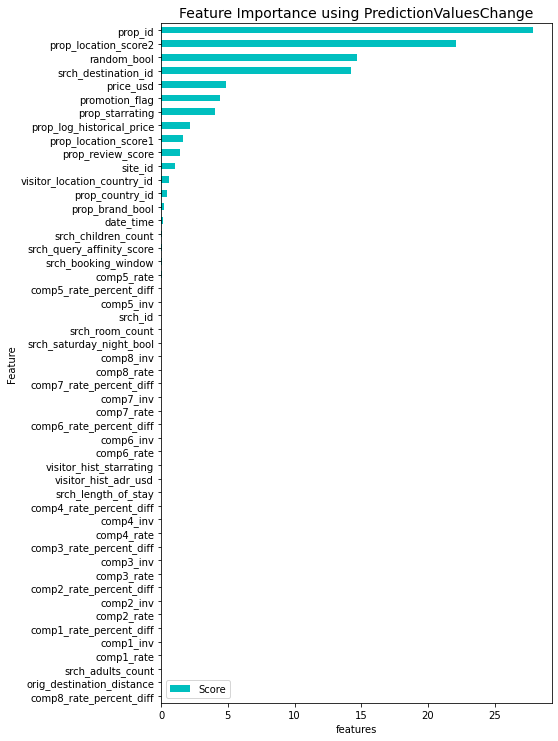

In [74]:
import matplotlib.pyplot as plt

for method in ['LossFunctionChange', 'PredictionValuesChange']:
    fi = model.get_feature_importance(test_pool, type=method)
    feature_score_raw = pd.DataFrame(list(zip(X_test.columns, fi)),
                                     columns=['Feature', 'Score'])

    feature_score = feature_score_raw.sort_values(
        by='Score', ascending=False)

    plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
    ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize=14)
    ax.set_xlabel("features")
    ax.invert_yaxis()
    plt.show()

In [75]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'QueryRMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:P

# Fit final model

In [76]:
params

{'iterations': 1000,
 'loss_function': 'QueryRMSE',
 'custom_metric': ['NDCG:top=5;type=Base;denominator=LogPosition'],
 'verbose': False,
 'early_stopping_rounds': 50}

In [77]:
params['iterations'] = 500

In [95]:
params

{'iterations': 500,
 'loss_function': 'QueryRMSE',
 'custom_metric': ['NDCG:top=5;type=Base;denominator=LogPosition'],
 'verbose': False,
 'early_stopping_rounds': 50}

In [96]:
CAT_FEATURES

['site_id',
 'visitor_location_country_id',
 'prop_country_id',
 'prop_id',
 'srch_destination_id']

In [78]:
model = CatBoostRanker(**params)
model.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Eval

In [117]:
test_clf_target = X_test.apply(get_target, axis=1)

In [118]:
test_clf_target.value_counts()

0    473618
5     13909
1      8308
dtype: int64

In [119]:
test_preds = model.predict(test_pool)

test_results_df = pd.DataFrame({group_col: groups_test,
                        'prop_id': X_test['prop_id'],
                        ranking_target: test_preds,
                        'gt_position': y_test,
                        'gt_gain': test_clf_target,
                         })
test_results_df.sort_values([group_col, 'position'], inplace=True)

test_results_df.head()

,srch_id,prop_id,position,gt_position,gt_gain
4462512,299424,99130,-8.581254,28,0
4462521,299424,135423,-6.821568,2,0
4462514,299424,107732,-2.203656,8,0
4462517,299424,127310,-1.480170,16,0
4462515,299424,109781,0.245352,6,0


In [146]:
from metrics import ndcg

In [154]:
print('NDCG which is used for competition evaluation')
test_results_df.groupby('srch_id')['gt_gain'].apply(ndcg, at=5).mean()

NDCG which is used for competition evaluation


0.3259516553522412

# Make preds

In [86]:
# subm_df = pd.read_csv('data/test_set_VU_DM.csv')
subm_df['date_time'] = pd.to_datetime(subm_df['date_time'])

subm_pool = Pool(
    data=subm_df,
    group_id=subm_df[group_col],
    cat_features=CAT_FEATURES,
)

In [92]:
pred = model.predict(subm_pool)

output_df = pd.DataFrame({group_col: subm_df[group_col],
                        'prop_id': subm_df['prop_id'],
                        ranking_target: pred,
#                         'gt': y_test
                         })

output_df.sort_values([group_col, 'position'], inplace=True)
output_df[[group_col, 'prop_id']].to_csv('sumbission.csv', index=False)
output_df.head(10)

,srch_id,prop_id,position
12,1,61934,-14.903637
23,1,99484,-14.194567
9,1,54937,-13.244090
8,1,50162,-12.770280
5,1,28181,-12.365165
1,1,5543,-10.631290
17,1,78599,-10.521110
25,1,128085,-7.834714
6,1,34263,-7.051518
16,1,74045,-5.039666


In [93]:
pd.read_csv('sumbission.csv', nrows=10)

,srch_id,prop_id
0,1,61934
1,1,99484
2,1,54937
3,1,50162
4,1,28181
5,1,5543
6,1,78599
7,1,128085
8,1,34263
9,1,74045


Score: 0.32661